<a href="https://colab.research.google.com/github/aaronc09/peds_lupus_flare_prediction_ML_gene-expression/blob/main/3_ML_TRAINING_EVALUATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pickle
import pandas as pd

drive_path = '/content/drive/MyDrive/lupus_final_df.pkl'
lupus_final_df = pd.read_pickle(drive_path)

extracted_cols_path = '/content/drive/MyDrive/features_selected.pkl'
with open(extracted_cols_path, 'rb') as f:
  features_selected = list(pickle.load(f))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 440 total samples from lupus office visits- 367 are non-pre-flare and 73 are pre-flare
lupus_final_df["preflare_bool"].value_counts()

,count
preflare_bool,
False,367
True,73


In [ ]:
# Number of gene-expressions selected from the feature-selection process
len(features_selected)

1979

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, average_precision_score, roc_auc_score, matthews_corrcoef
import random
import matplotlib.pyplot as plt
import shutil
import os

In [ ]:
# y= binary target outcome data- "True" for pre-flare and "False" for non-pre-flare, that will be used to train ML models to predict
# X= input data with feature-selected gene-expressions that will be used to train/ test ML models to predict the target outcome
y = lupus_final_df["preflare_bool"]
X = lupus_final_df[features_selected]

# Setting up hyperparameter sets for gridsearch
param_grids = {
    "KNN": {
        "n_neighbors": [3, 5, 7, 11],
        "weights": ["uniform", "distance"],
    },
    "LogisticRegression": {
        "C": [0.001, 0.01, 0.1, 1, 10],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"],
        "class_weight": [None, "balanced"]
    },
    "SVM_linear": {
        "C": [0.1, 1, 10],
        "kernel": ["linear"],
        "class_weight": [None, "balanced"]
    },
    "SVM": {
        "C": [0.1, 1, 10, 20],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf"],
        "class_weight": [None, "balanced"]
    },
    "GaussianNB": {
         "var_smoothing": [1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01],
    },
    "RandomForest": {
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "n_estimators": [50, 100, 200],
        "class_weight": [None, "balanced", "balanced_subsample"]
    },
    "XGBoost": {
        "learning_rate": [0.1, 0.3, 0.5],
        "max_depth": [1, 3, 6],
        "n_estimators": [100, 200, 500, 700],
    },
    "NeuralNet": {
        "hidden_layer_sizes": [(50,), (100,), (200,), (50, 50)],
        "activation": ["relu", "tanh"],
        "alpha": [0.0001, 0.001, 0.01],
    },

}

# Create new lists to store results from all 5 random seed runs
all_results = []
all_confusion_matrices = []

# Set up different random seeds to run 5 times
random.seed(42)
SEEDS = random.sample(range(1, 10000), 5)
for seed in SEEDS:
  print(f"\nRunning experiments with random seed: {seed}")

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

  results = {}
  for model_name, param_grid in param_grids.items():
      print(f"Running GridSearchCV for {model_name}...")

      if model_name == "KNN":
          base_model = KNeighborsClassifier()
      elif model_name == "LogisticRegression":
          base_model = LogisticRegression(random_state=seed, max_iter=1000)
      elif model_name == "SVM_linear":
          base_model = SVC(random_state=seed, probability=True)
      elif model_name == "SVM":
          base_model = SVC(random_state=seed, probability=True)
      elif model_name == "GaussianNB":
          base_model = GaussianNB()
      elif model_name == "RandomForest":
          base_model = RandomForestClassifier(random_state=seed)
      elif model_name == "XGBoost":
          base_model = XGBClassifier(random_state=seed, eval_metric='logloss')
      elif model_name == "NeuralNet":
          base_model = MLPClassifier(random_state=seed, max_iter=1000)

      # Exclude tree-based models from scaling data
      if model_name in ["RandomForest", "XGBoost"]:
          pipe = Pipeline([
                ("model", base_model)
          ])
      else:
          pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("model", base_model)
          ])

      param_grid_pipe = {f"model__{k}": v for k, v in param_grid.items()}

      # Set up Stratified 5-fold training/test data splits
      cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

      # Use the pipeline and parameter grid for GridSearchCV
      grid_search = GridSearchCV(pipe, param_grid_pipe, cv=cv, scoring='f1', n_jobs=-1)

      # Fit training data to GridSearchCV
      grid_search.fit(X_train, y_train)

      best_model = grid_search.best_estimator_

      # Make predictions on the test data using the best model paramters
      y_pred = best_model.predict(X_test)

      # Obtain predict_proba probability for later metric use
      y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

      # Setting up for metric evaluations
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred, zero_division=0)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)
      roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
      pr_auc = average_precision_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
      mcc = matthews_corrcoef(y_test, y_pred)
      confusion_mat = confusion_matrix(y_test, y_pred)

      results[model_name] = {
          "best_params": grid_search.best_params_,
          "best_score": grid_search.best_score_,
          "f1_score": f1,
          "recall": recall,
          "precision": precision,
          "accuracy": accuracy,
          "roc_auc": roc_auc,
          "pr_auc": pr_auc,
          "mcc": mcc,
          "confusion_matrix": confusion_mat,
      }

      # Add results for the current model and seed to "all_results" list
      all_results.append({
          "model": model_name,
          "f1": f1,
          "recall": recall,
          "precision": precision,
          "accuracy": accuracy,
          "roc_auc": roc_auc if roc_auc != "N/A" else None,
          "pr_auc": pr_auc if pr_auc != "N/A" else None,
          "mcc": mcc
      })

      # Store Confusion Matrix displays
      cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0, 1])
      all_confusion_matrices.append((f"{model_name} (Seed {seed})", cm_display))

      # Print all results
      print(f"Results for {model_name}, train/test split seed {seed}:")
      print("   " f"Best parameters: {results[model_name]['best_params']}")
      print("   " f"Best cross-validation F1-score: {results[model_name]['best_score']:.2f}")
      print("\nPerformance Metrics on the Test Dataset:")
      print("   " f"F1 Score: {results[model_name]['f1_score']:.2f}")
      print("   " f"Recall: {results[model_name]['recall']:.1%}")
      print("   " f"Precision: {results[model_name]['precision']:.1%}")
      print("   " f"Accuracy: {results[model_name]['accuracy']:.1%}")
      if isinstance(results[model_name]['pr_auc'], (int, float)):
          print("   " f"PR-AUC: {results[model_name]['pr_auc']:.2f}")
      else:
          print("   " f"PR-AUC: {results[model_name]['pr_auc']}")
      if isinstance(results[model_name]['roc_auc'], (int, float)):
          print("   " f"ROC-AUC: {results[model_name]['roc_auc']:.2f}")
      else:
          print("   " f"ROC-AUC: {results[model_name]['roc_auc']}")
      print("   " f"MCC: {results[model_name]['mcc']:.2f}")

      print("-" * 60)


Running experiments with random seed: 1825
Running GridSearchCV for KNN...
Results for KNN, train/test split seed 1825:
   Best parameters: {'model__n_neighbors': 3, 'model__weights': 'uniform'}
   Best cross-validation F1-score: 0.09

Performance Metrics on the Test Dataset:
   F1 Score: 0.11
   Recall: 6.7%
   Precision: 25.0%
   Accuracy: 80.7%
   PR-AUC: 0.19
   ROC-AUC: 0.54
   MCC: 0.05
------------------------------------------------------------
Running GridSearchCV for LogisticRegression...
Results for LogisticRegression, train/test split seed 1825:
   Best parameters: {'model__C': 10, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}
   Best cross-validation F1-score: 0.54

Performance Metrics on the Test Dataset:
   F1 Score: 0.61
   Recall: 66.7%
   Precision: 55.6%
   Accuracy: 85.2%
   PR-AUC: 0.78
   ROC-AUC: 0.92
   MCC: 0.52
------------------------------------------------------------
Running GridSearchCV for SVM_linear...
Results

### >> Create a figure with Confusion Matrices from the first 3 random seed runs.

### >> Create a figure with Confusion Matrices from the last 2 random seed runs.

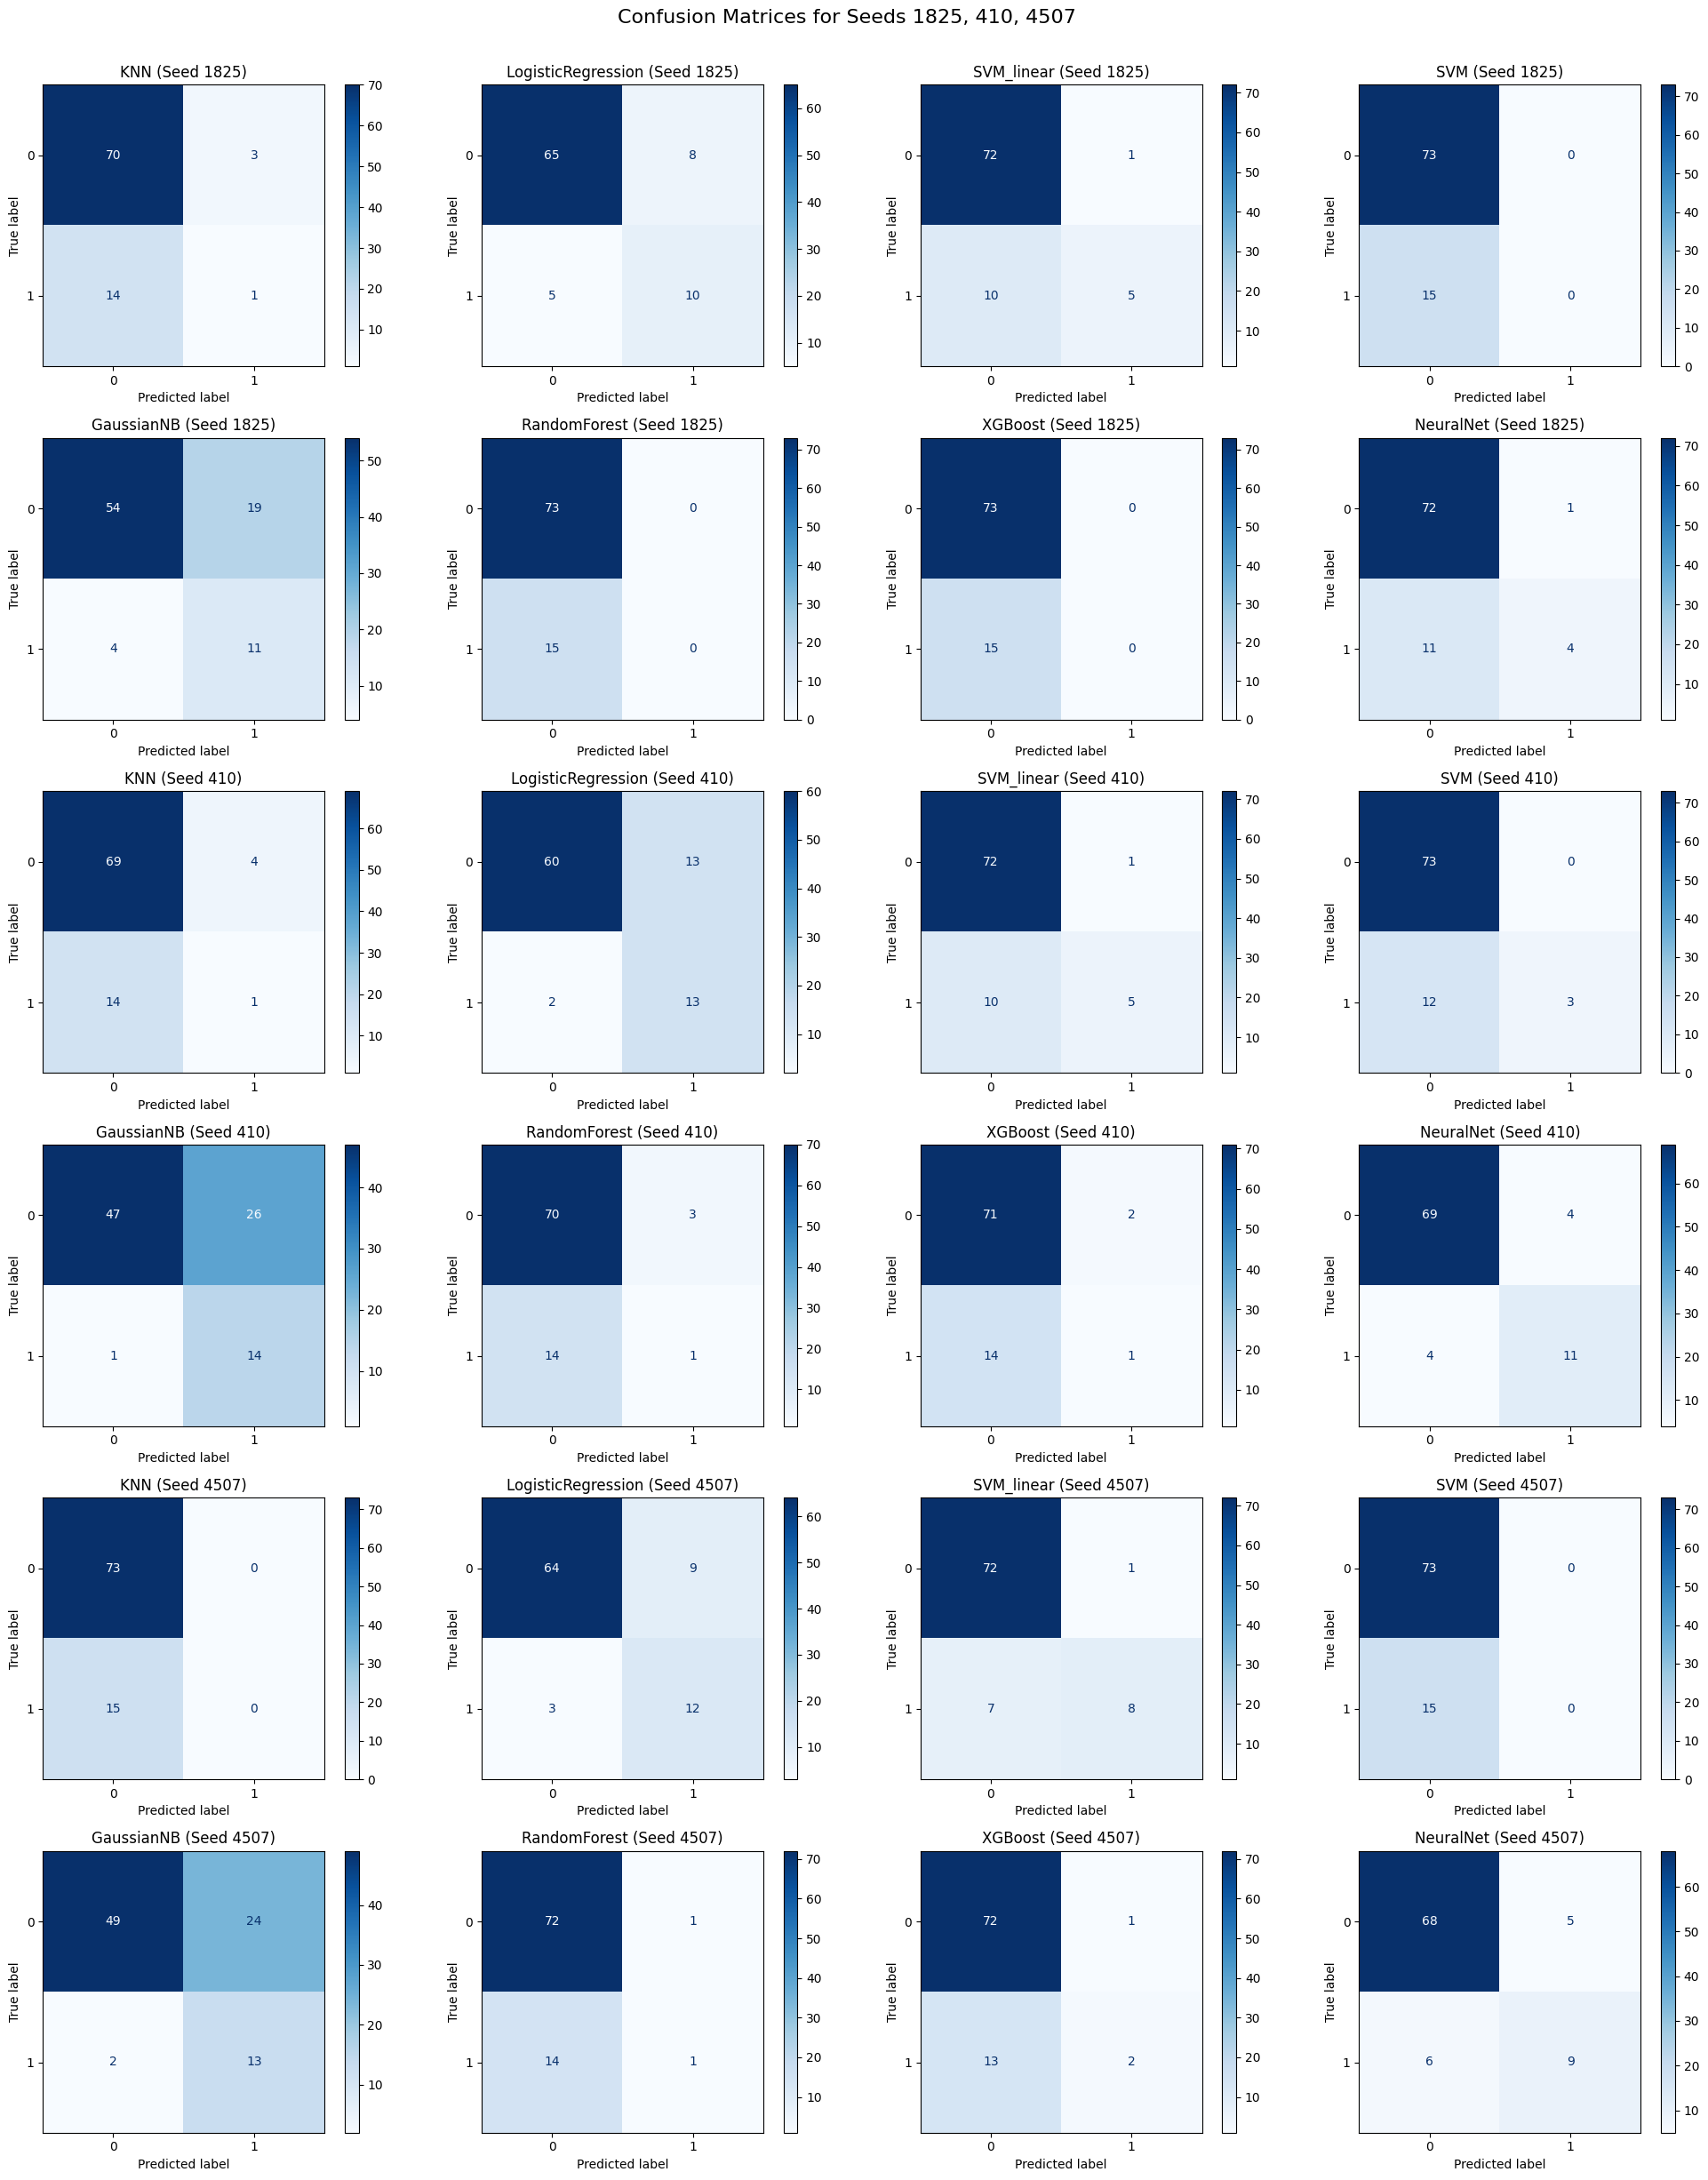

In [ ]:
seeds_1_2_3 = SEEDS[0:3]

filtered_confusion_matrices = []
for title, cm_display in all_confusion_matrices:
    try:
        seed_str = title.split('(Seed ')[1].split(')')[0]
        seed = int(seed_str)
        if seed in seeds_1_2_3:
            filtered_confusion_matrices.append((title, cm_display))
    except (IndexError, ValueError):
        pass

num_filtered_models = len(filtered_confusion_matrices)

if num_filtered_models > 0:
    cols = 4
    rows = (num_filtered_models + cols - 1) // cols

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4))

    axes = axes.flatten()

    for i, (title, cm_display) in enumerate(filtered_confusion_matrices):
        ax = axes[i]
        cm_display.plot(ax=ax, cmap='Blues')
        ax.set_title(title)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f"Confusion Matrices for Seeds {', '.join(map(str, seeds_1_2_3))}", y=1.02, fontsize=16)

    save_folder = '/content/drive/MyDrive/figures/'
    output_filename = 'confusion_matrices_from_frist_3_random_seeds'
    output_path = os.path.join(save_folder, output_filename)

    os.makedirs(save_folder, exist_ok=True)

    plt.savefig(output_path)

    plt.show()
    plt.close(fig)
else:
    print(f"No confusion matrices found for seeds {seeds_1_2_3}. Skipping plot generation.")

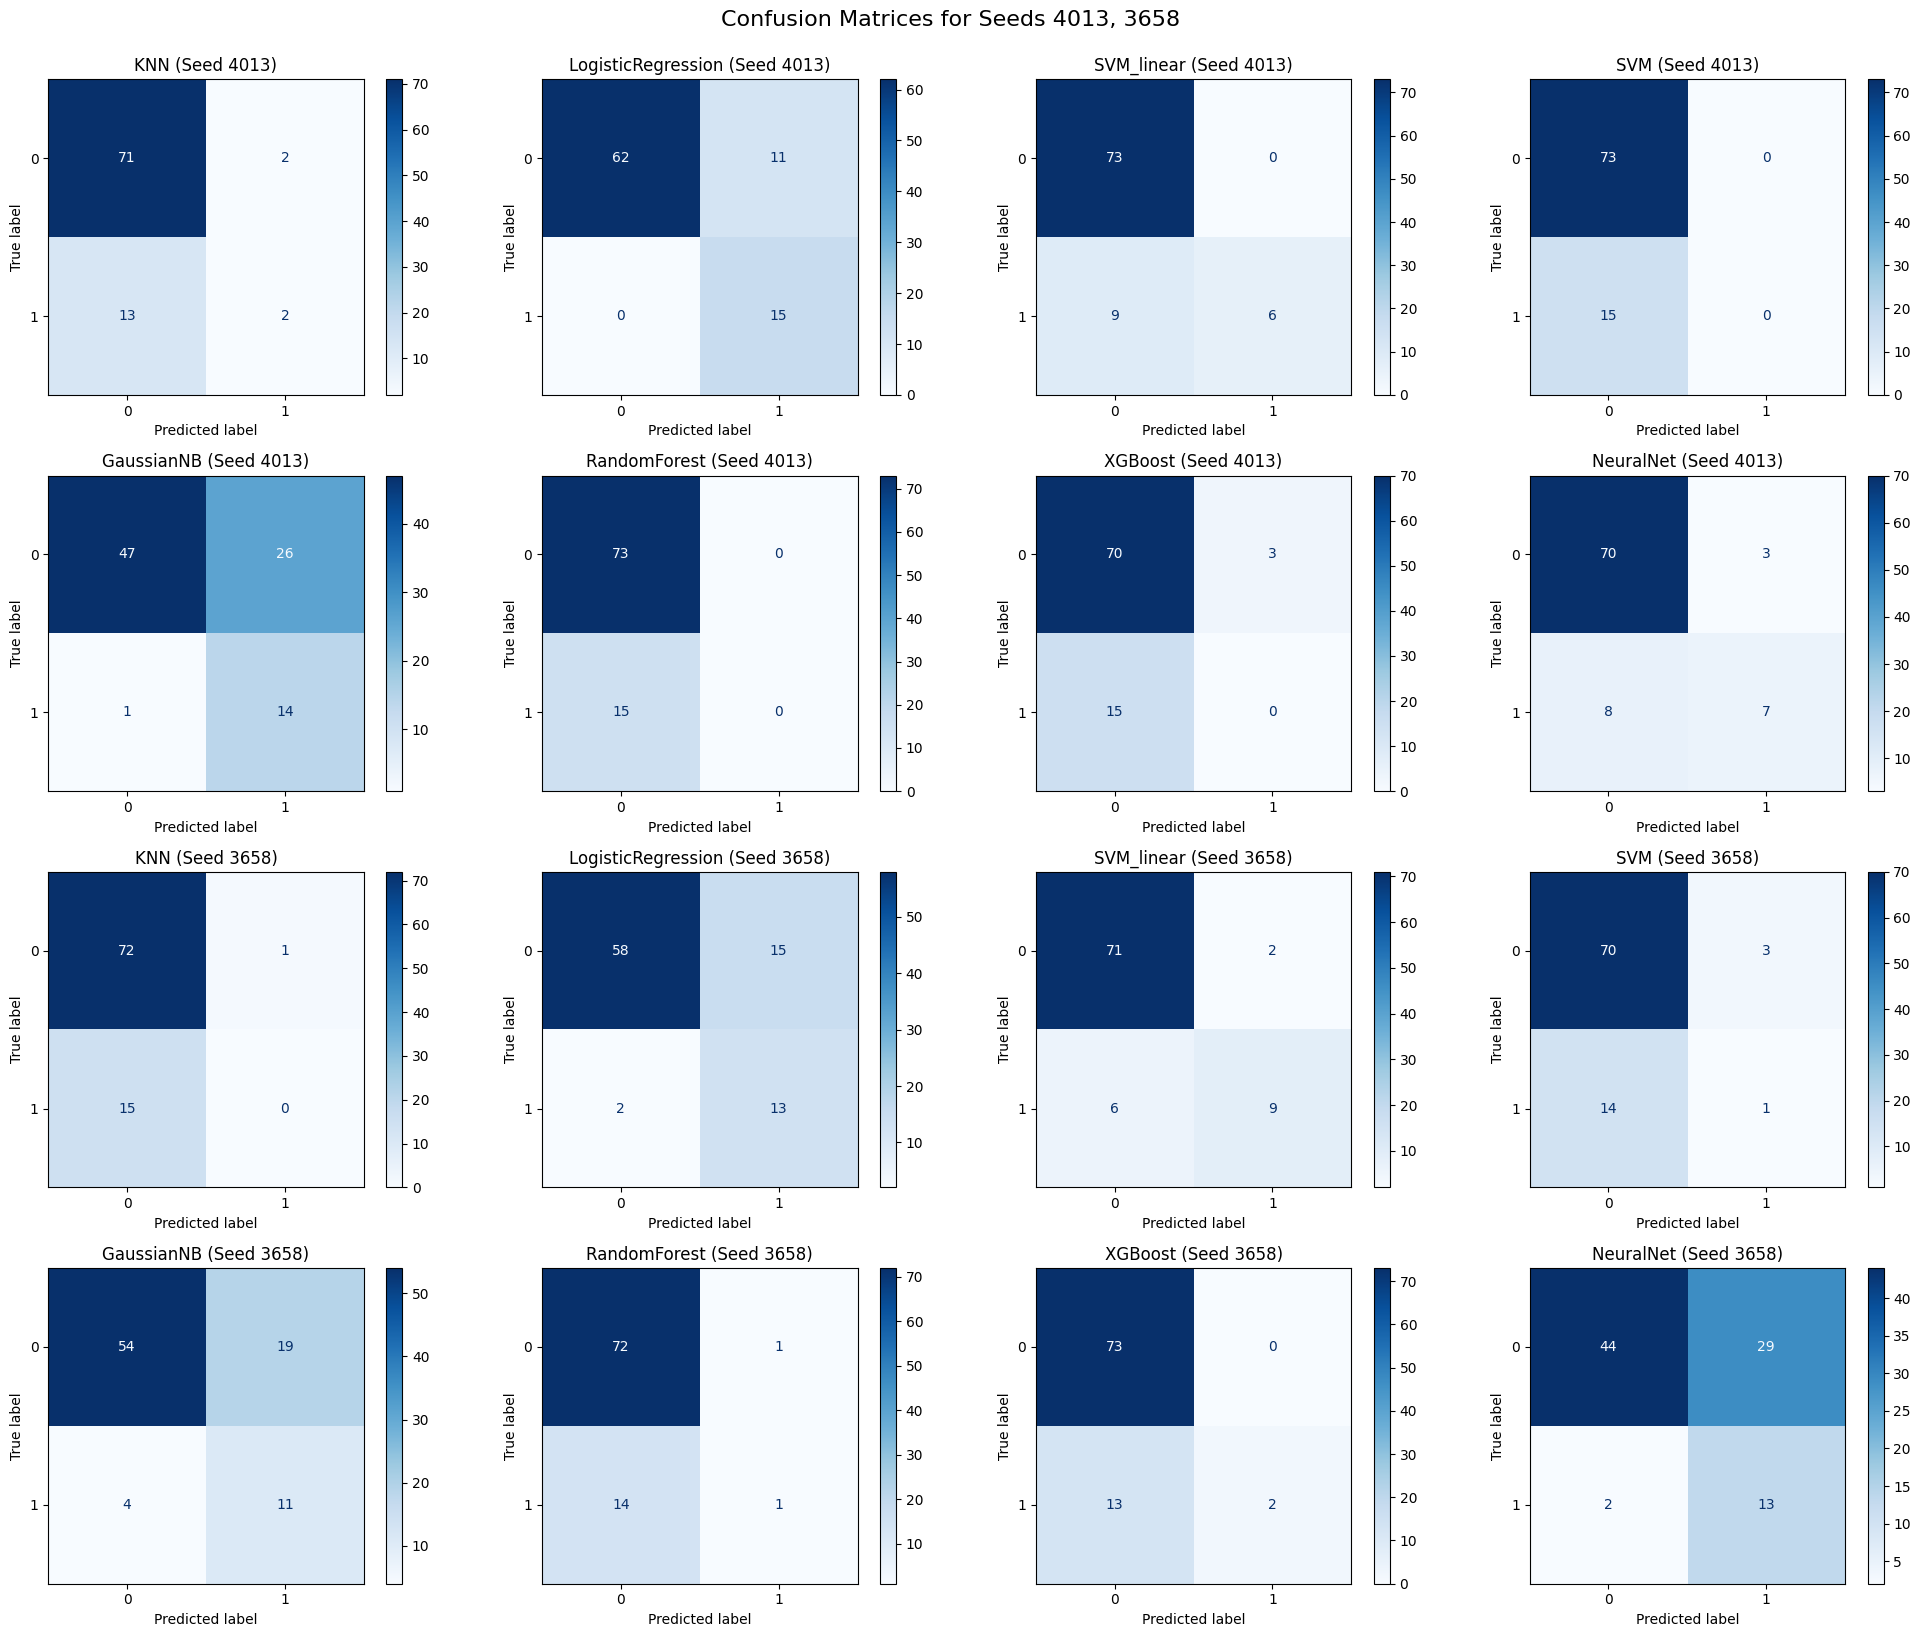

In [ ]:
seeds_4_5 = SEEDS[3:5]

filtered_confusion_matrices_4_5 = []
for title, cm_display in all_confusion_matrices:
    try:
        seed_str = title.split('(Seed ')[1].split(')')[0]
        seed = int(seed_str)
        if seed in seeds_4_5:
            filtered_confusion_matrices_4_5.append((title, cm_display))
    except (IndexError, ValueError):
        pass

num_filtered_models_4_5 = len(filtered_confusion_matrices_4_5)

if num_filtered_models_4_5 == 0:
    print(f"No confusion matrices found for seeds {seeds_4_5}. Skipping plot generation.")
else:
    cols = 4
    rows = (num_filtered_models_4_5 + cols - 1) // cols
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, (title, cm_display) in enumerate(filtered_confusion_matrices_4_5):
        ax = axes[i]
        cm_display.plot(ax=ax, cmap='Blues')
        ax.set_title(title)

    for j in range(num_filtered_models_4_5, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(f"Confusion Matrices for Seeds {', '.join(map(str, seeds_4_5))}", y=1.02, fontsize=16) # Adjusted y-position to 1.02

    save_folder = '/content/drive/MyDrive/figures/'
    output_filename = 'confusion_matrices_from_last_2_random_seeds.png'
    output_path = os.path.join(save_folder, output_filename)

    os.makedirs(save_folder, exist_ok=True)

    plt.savefig(output_path)

    plt.show()
    plt.close(fig)

### >> Create a chart with average of all metric outcomes for each model across all 5 random seed runs

In [16]:
print("FINAL RESULTS: AVERAGE METRICS ACROSS THE 5 RANDOM SEED RUNS FOR EACH MODEL:")

avg_results = all_results_df.groupby("model").mean(numeric_only=True)

desired_order = ['KNN', 'LogisticRegression', 'SVM_linear', 'SVM', 'GaussianNB', 'RandomForest', 'XGBoost', 'NeuralNet']
avg_results_ordered = avg_results.reindex(desired_order)

format_dict = {"f1": "{:.2f}",
               "recall": "{:.1%}",
               "precision": "{:.1%}",
               "accuracy": "{:.1%}",
               "pr_auc": "{:.2f}",
               "roc_auc": "{:.2f}",
               "mcc": "{:.2f}"}

formatted_avg_results = avg_results_ordered.style.format(format_dict)

display(formatted_avg_results)

fig, ax = plt.subplots(figsize=(12, len(avg_results_ordered) * 0.6))
ax.axis('off')
ax.axis('tight')

table_data_df = avg_results_ordered.copy()
for col, fmt_str in format_dict.items():
    if col in table_data_df.columns:
        table_data_df[col] = table_data_df[col].apply(lambda x: fmt_str.format(x) if pd.notna(x) else 'N/A')

table = ax.table(cellText=table_data_df.values,
                 colLabels=table_data_df.columns.values,
                 rowLabels=table_data_df.index.values,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(9)

for i in range(len(table_data_df.columns)):
    table.auto_set_column_width(col=i)
table.scale(1.2, 1.2)

save_folder = '/content/drive/MyDrive/figures/'
figure_path = os.path.join(save_folder, 'average_performance_metrics.png')
plt.savefig(figure_path, dpi=300, bbox_inches='tight')
plt.close(fig)

FINAL RESULTS: AVERAGE METRICS ACROSS THE 5 RANDOM SEED RUNS FOR EACH MODEL:


,f1,recall,precision,accuracy,roc_auc,pr_auc,mcc
model,,,,,,,
KNN,0.08,5.3%,19.0%,81.6%,0.54,0.21,0.04
LogisticRegression,0.65,84.0%,53.4%,84.5%,0.93,0.80,0.58
SVM_linear,0.58,44.0%,87.5%,89.3%,0.92,0.77,0.57
SVM,0.09,5.3%,25.0%,83.2%,0.43,0.25,0.09
GaussianNB,0.50,84.0%,35.7%,71.4%,0.79,0.37,0.41
RandomForest,0.07,4.0%,25.0%,82.5%,0.60,0.27,0.06
XGBoost,0.11,6.7%,40.0%,82.7%,0.66,0.32,0.12
NeuralNet,0.55,58.7%,63.7%,83.4%,0.90,0.74,0.50
